<a href="https://colab.research.google.com/github/av-dutta/Bank-Marketing-Effectiveness-Prediction/blob/main/Bank_Marketing_Effectiveness_Prediction_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Description
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe a term deposit (variable y).

## Data Description
Input variables:

Bank Client data:

age (numeric) job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

default: has credit in default? (categorical: 'no','yes','unknown')

housing: has housing loan? (categorical: 'no','yes','unknown')

loan: has personal loan? (categorical: 'no','yes','unknown')

Related with the last contact of the current campaign:

contact: contact communication type (categorical: 'cellular','telephone')

month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Other attributes:

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

previous: number of contacts performed before this campaign and for this client (numeric)

poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Social and economic context attributes

emp.var.rate: employment variation rate - quarterly indicator (numeric)

cons.price.idx: consumer price index - monthly indicator (numeric)

cons.conf.idx: consumer confidence index - monthly indicator (numeric)

euribor3m: euribor 3 month rate - daily indicator (numeric)

nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

y - has the client subscribed a term deposit? (binary: 'yes','no')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries

import numpy as np
import pandas as pd
import scipy.stats
import missingno
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.express as ex
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [ ]:
# Loading the data
file_path = '/content/drive/MyDrive/Capstone project classification/bank-full.csv'

data= pd.read_csv(file_path,sep = ';')

# Make a copy of the dataset
df = data.copy()

# Display first 5 rows
df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [ ]:
# Checking shape of dataset

print('Bank Marketing Effectiveness dataset - rows:', df.shape[0],' columns:', df.shape[1])

Bank Marketing Effectiveness dataset - rows: 45211  columns: 17


In [ ]:
# Checking for the null values

df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There is no null value present in the given dataset

In [ ]:
# Rename housing,loan and poutcome to housing_loan, personal_loan and prev_outcome 

df.rename(columns = {'housing': 'housing_loan', 
                     'loan': 'personal_loan',
                     'poutcome': 'prev_outcome'}, 
          inplace = True)

In [ ]:
# List of categorical columns

categorical_features = [col for col 
                            in dict(df.dtypes) 
                            if dict(df.dtypes)[col] 
                            in ['object']]

# Categorical features and their number of levels

print(df[categorical_features].nunique())

job              12
marital           3
education         4
default           2
housing_loan      2
personal_loan     2
contact           3
month            12
prev_outcome      4
y                 2
dtype: int64


In [ ]:
# Display all categorical values

for col in list(df.columns[df.dtypes == 'object']):
    print('\n',col+' :')
    print(df[col].unique())


 job :
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

 marital :
['married' 'single' 'divorced']

 education :
['tertiary' 'secondary' 'unknown' 'primary']

 default :
['no' 'yes']

 housing_loan :
['yes' 'no']

 personal_loan :
['no' 'yes']

 contact :
['unknown' 'cellular' 'telephone']

 month :
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

 prev_outcome :
['unknown' 'failure' 'other' 'success']

 y :
['no' 'yes']


In [ ]:
# List of numerical columns

num_features = df.columns[df.dtypes != 'object']

# Numerical features and their number of levels

df[num_features].nunique().rename('Unique Counts').to_frame()

Unique Counts
age                  77
balance            7168
day                  31
duration           1573
campaign             48
pdays               559
previous             41

In [ ]:
# generate count statistics of duplicate entries

if (len(df[df.duplicated()]) > 0):
    print('No. of duplicated entries: ', len(df[df.duplicated()]))
    print(df[df.duplicated(keep = False)].sort_values(by = list(df.columns)).head())
else:
    print('No duplicated entries found')

No duplicated entries found


In [ ]:
# Statistical Summary of the dataset

df.describe([0.8, 0.9, 0.95, 0.99]).T

count         mean          std     min    50%     80%     90%  \
age       45211.0    40.936210    10.618762    18.0   39.0    51.0    56.0   
balance   45211.0  1362.272058  3044.765829 -8019.0  448.0  1859.0  3574.0   
day       45211.0    15.806419     8.322476     1.0   16.0    24.0    28.0   
duration  45211.0   258.163080   257.527812     0.0  180.0   368.0   548.0   
campaign  45211.0     2.763841     3.098021     1.0    2.0     4.0     5.0   
pdays     45211.0    40.197828   100.128746    -1.0   -1.0    -1.0   185.0   
previous  45211.0     0.580323     2.303441     0.0    0.0     0.0     2.0   

             95%      99%       max  
age         59.0     71.0      95.0  
balance   5768.0  13164.9  102127.0  
day         29.0     31.0      31.0  
duration   751.0   1269.0    4918.0  
campaign     8.0     16.0      63.0  
pdays      317.0    370.0     871.0  
previous     3.0      8.9     275.0

In [ ]:
df.head()

age           job  marital  education default  balance housing_loan  \
0   58    management  married   tertiary      no     2143          yes   
1   44    technician   single  secondary      no       29          yes   
2   33  entrepreneur  married  secondary      no        2          yes   
3   47   blue-collar  married    unknown      no     1506          yes   
4   33       unknown   single    unknown      no        1           no   

  personal_loan  contact  day month  duration  campaign  pdays  previous  \
0            no  unknown    5   may       261         1     -1         0   
1            no  unknown    5   may       151         1     -1         0   
2           yes  unknown    5   may        76         1     -1         0   
3            no  unknown    5   may        92         1     -1         0   
4            no  unknown    5   may       198         1     -1         0   

  prev_outcome   y  
0      unknown  no  
1      unknown  no  
2      unknown  no  
3      unknown  no  
4      unknown  no

# Exploratory Data Analysis

##Univariate Analysis

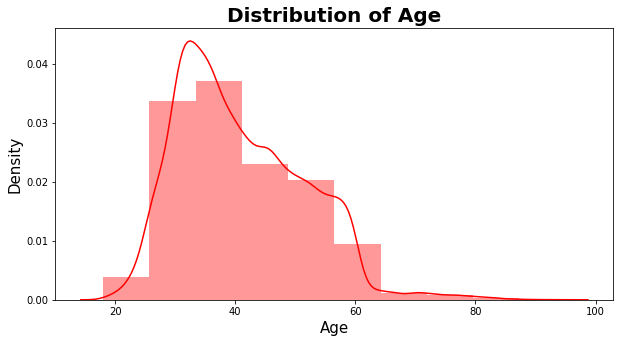

In [ ]:
# Age

plt.figure(figsize = (10, 5))
sns.distplot(df['age'], color ='red', bins = 10)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Distribution of Age', fontsize = 20, weight = 'bold')
plt.show();

- Age is slightly right skewed.
- Minimum age is 18
- Maximum age is 95
- Most of the clients are falling in the age bracket of 25 to 60 years

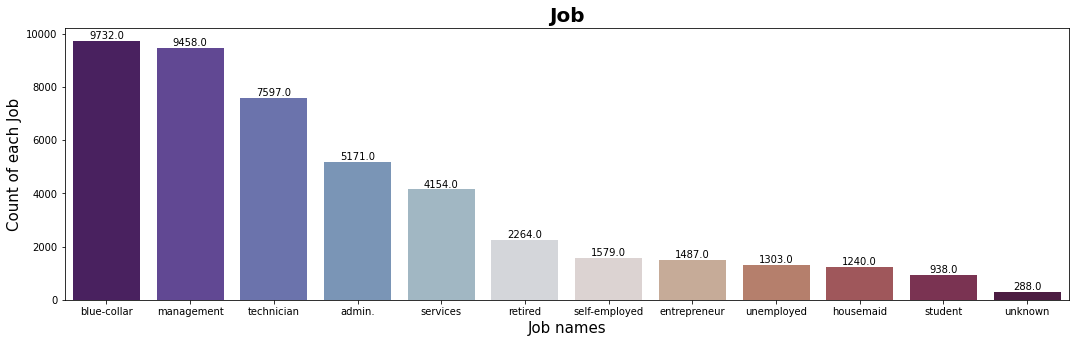

In [ ]:
# Job

f, ax = plt.subplots(figsize = (18,5))
job = df['job'].value_counts()
cplot = sns.barplot(job.index, job, palette = 'twilight_shifted')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title('Job', fontsize = 20, weight = 'bold')
cplot.set_ylabel('Count of each Job', fontsize = 15)
cplot.set_xlabel('Job names', fontsize = 15);

- There exists around 12 different type of job profiles.
- Top 3 job profiles are blue-collar, managment and technician which contains 60% of the total records.
- Job description of 288 clients are unknown.

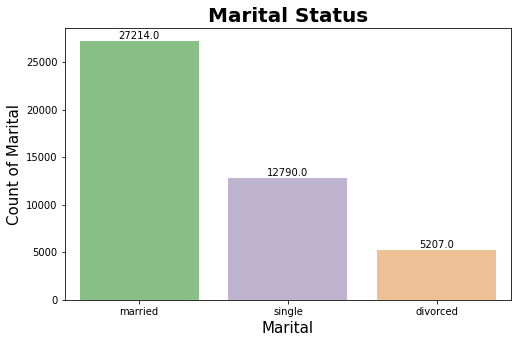

In [ ]:
# Marital

f, ax = plt.subplots(figsize = (8,5))
marital_status = df['marital'].value_counts()
cplot = sns.barplot(marital_status.index, marital_status, palette = 'Accent')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title('Marital Status', fontsize = 20, weight = 'bold')
cplot.set_ylabel('Count of Marital', fontsize = 15)
cplot.set_xlabel('Marital', fontsize = 15);

- Around 60% of our client base is married, 28% is single and 12% are divorced.



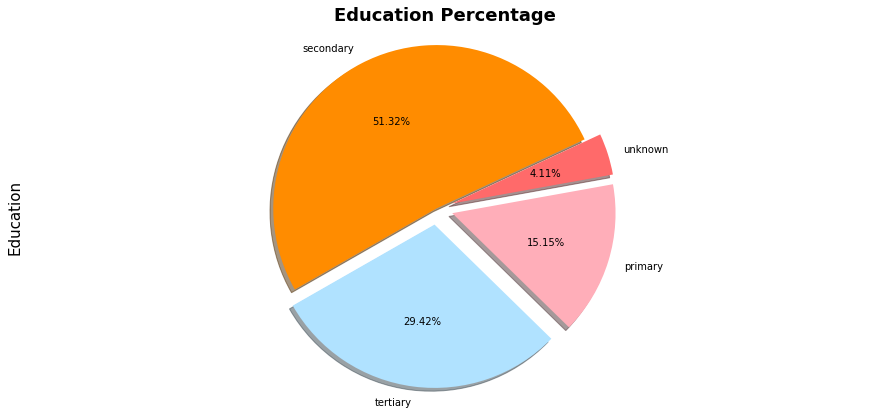

In [ ]:
# Education

fig, ax = plt.subplots(figsize = (15, 7))
colors = ['#FF8C00', '#B0E2FF', '#FFAEB9', '#FF6A6A']
explode = (0, 0.1, 0.1, 0.1)
ax = df.education.value_counts().plot(kind = 'pie', explode = explode, 
                                      colors = colors, shadow = True, 
                                      startangle = 25, autopct ='%1.2f%%')
plt.title('Education Percentage', fontsize = 18, weight = 'bold')
plt.ylabel('Education', fontsize = 15)
plt.axis('equal')
plt.show()

- 51% of clients has secondary school degree.
- 30% has tertiary and 15% has primary education degree while rest 4% are unknown.

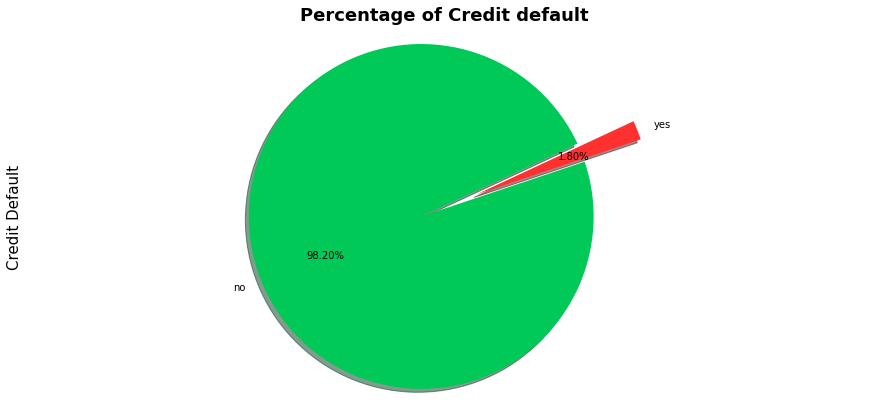

In [ ]:
# Default

fig, ax = plt.subplots(figsize = (15, 7))
colors = ['#00C957', '#FF3030']
explode = (0.25, 0.1)
ax = df.default.value_counts().plot(kind = 'pie', explode = explode, 
                                      colors = colors, shadow = True, 
                                      startangle = 25, autopct ='%1.2f%%')
plt.title('Percentage of Credit default', fontsize = 18, weight = 'bold')
plt.ylabel('Credit Default', fontsize = 15)
plt.axis('equal')
plt.show()

- Around 2% of recorded clients have once defaulted to any credit.

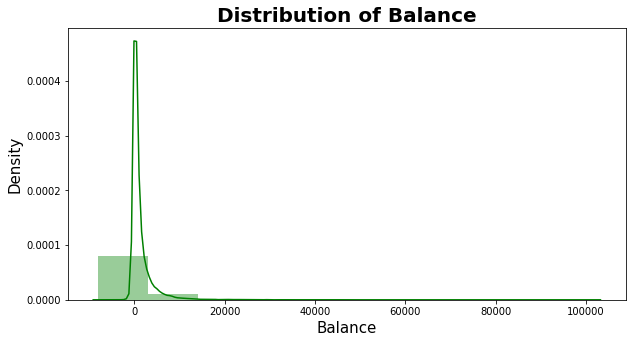

In [ ]:
# Balance

plt.figure(figsize = (10,5))
sns.distplot(df['balance'], color ='green', bins = 10)
plt.xlabel('Balance', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Distribution of Balance', fontsize = 20, weight = 'bold')
plt.show();

- Distribution of Balance is highly right skewed.
- Most of the account holders have 0 balance. 
- Some of them having negative balance that might be due to some annual maintainance charge deduction.

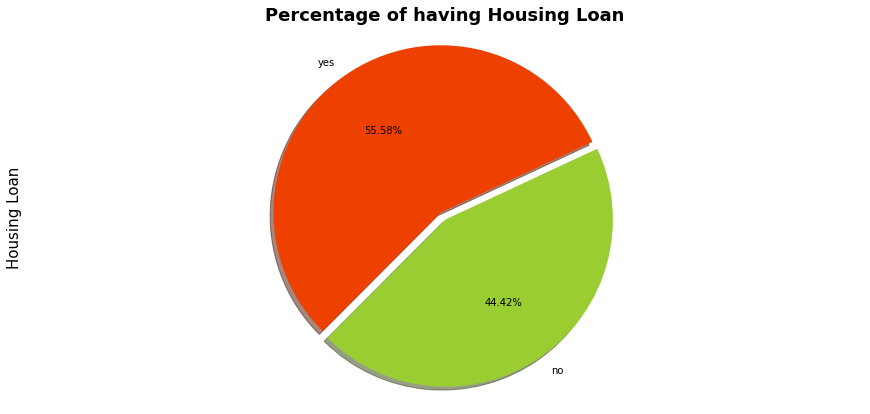

In [ ]:
# Housing loan

fig, ax = plt.subplots(figsize = (15, 7))
colors = ['#EE4000', '#9ACD32']
explode = (0, 0.05)
ax = df.housing_loan.value_counts().plot(kind = 'pie', explode = explode, 
                                      colors = colors, shadow = True, 
                                      startangle = 25, autopct ='%1.2f%%')
plt.title('Percentage of having Housing Loan', fontsize = 18, weight = 'bold')
plt.ylabel('Housing Loan', fontsize = 15)
plt.axis('equal')
plt.show()

- About 55% of recorded clients have credit history of housing loan.

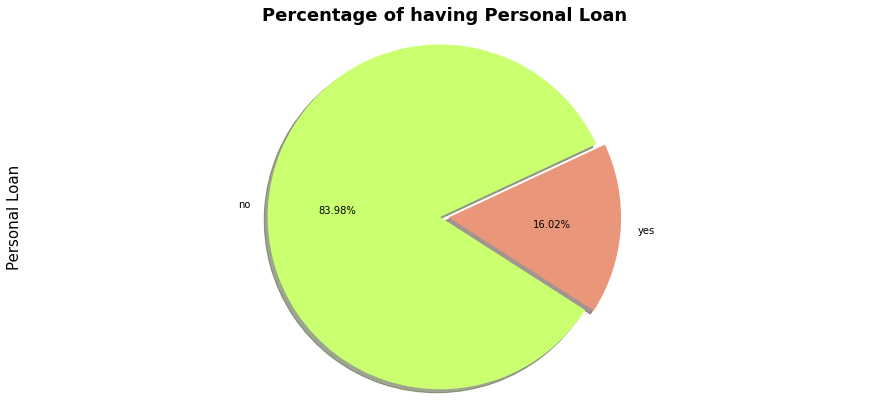

In [ ]:
# Personal loan

fig, ax = plt.subplots(figsize = (15, 7))
colors = ['#CAFF70', '#E9967A']
explode = (0, 0.05)
ax = df.personal_loan.value_counts().plot(kind = 'pie', explode = explode, 
                                      colors = colors, shadow = True, 
                                      startangle = 25, autopct ='%1.2f%%')
plt.title('Percentage of having Personal Loan', fontsize = 18, weight = 'bold')
plt.ylabel('Personal Loan', fontsize = 15)
plt.axis('equal')
plt.show()

- Almost 84% of total clients have already availed personal loan. 

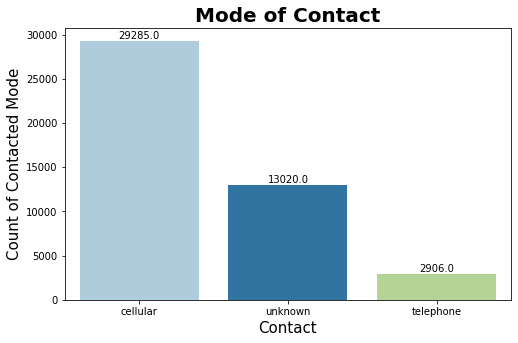

In [ ]:
# Contact

f, ax = plt.subplots(figsize = (8,5))
contact = df['contact'].value_counts()
cplot = sns.barplot(contact.index, contact, palette = 'Paired')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title('Mode of Contact', fontsize = 20, weight = 'bold')
cplot.set_ylabel('Count of Contacted Mode', fontsize = 15)
cplot.set_xlabel('Contact', fontsize = 15);


- Most popular mode of communication is cellular.

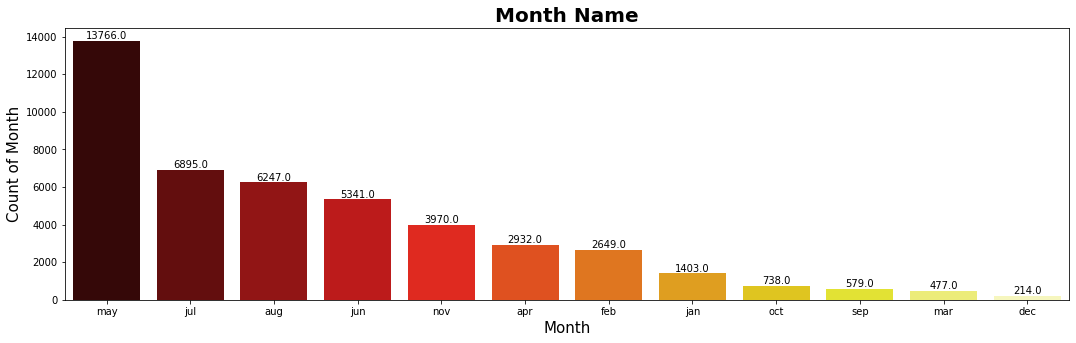

In [ ]:
# Month

f, ax = plt.subplots(figsize = (18,5))
month = df['month'].value_counts()
cplot = sns.barplot(month.index, month, palette = 'hot')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title('Month Name', fontsize = 20, weight = 'bold')
cplot.set_ylabel('Count of Month', fontsize = 15)
cplot.set_xlabel('Month', fontsize = 15);

- Most of the contact to the clients are made in the second and third quarters of the Portuguese financial year.

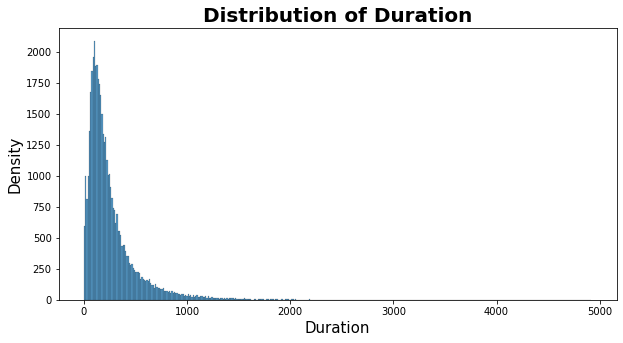

In [ ]:
# Duration

plt.figure(figsize = (10,5))
sns.histplot(x = 'duration', data = df, palette = 'plasma');
plt.xlabel('Duration', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Distribution of Duration', fontsize = 20, weight = 'bold')
plt.show();

In [ ]:
# Since the duration is not known till the call is confirmed so we can drop this column:

df.drop('duration', axis = 1, inplace = True)

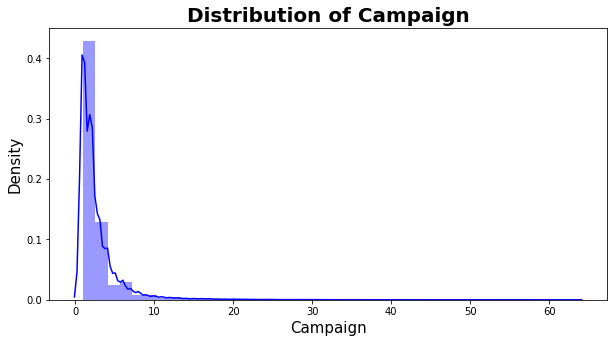

In [ ]:
# Campaign

plt.figure(figsize = (10,5))
sns.distplot(df['campaign'], color ='blue', bins = 40)
plt.xlabel('Campaign', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Distribution of Campaign', fontsize = 20, weight = 'bold')
plt.show();

In [ ]:
df.campaign.value_counts().head()

1    17544
2    12505
3     5521
4     3522
5     1764
Name: campaign, dtype: int64

- Customers are contacted mostly once or twice during the campaign.

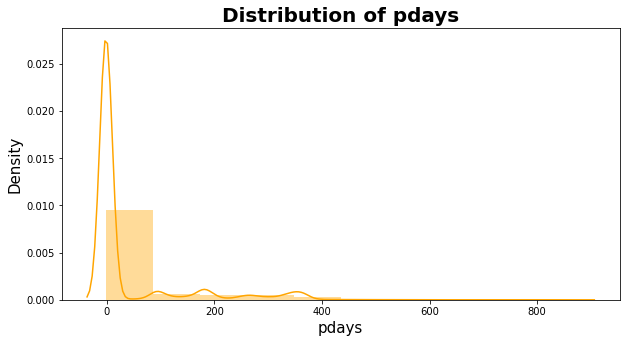

In [ ]:
# Pdays

plt.figure(figsize = (10,5))
sns.distplot(df['pdays'], color ='orange', bins = 10)
plt.xlabel('pdays', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Distribution of pdays', fontsize = 20, weight = 'bold')
plt.show();

In [ ]:
df.pdays.value_counts().head()

-1      36954
 182      167
 92       147
 91       126
 183      126
Name: pdays, dtype: int64

- 82% of the clients are not contacted after the previous campaign.

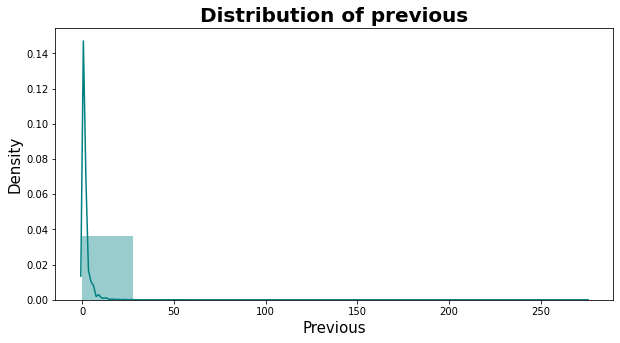

In [ ]:
# Previous

plt.figure(figsize = (10,5))
sns.distplot(df['previous'], color ='teal', bins = 10)
plt.xlabel('Previous', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Distribution of previous', fontsize = 20, weight = 'bold')
plt.show();

In [ ]:
df.previous.value_counts().head()

0    36954
1     2772
2     2106
3     1142
4      714
Name: previous, dtype: int64

- 82% of the clients were not contacted before this campaign.

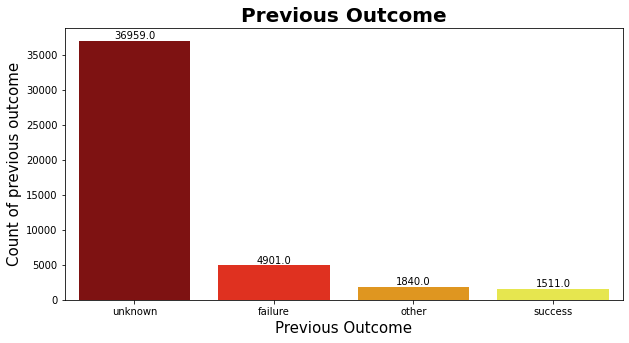

In [ ]:
# Previous Outcome

f, ax = plt.subplots(figsize = (10,5))
previous_outcome = df['prev_outcome'].value_counts()
cplot = sns.barplot(previous_outcome.index, previous_outcome, palette = 'hot')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title('Previous Outcome', fontsize = 20, weight = 'bold')
cplot.set_ylabel('Count of previous outcome', fontsize = 15)
cplot.set_xlabel('Previous Outcome', fontsize = 15);

- Around 80% of the results of previous outcome has no record.

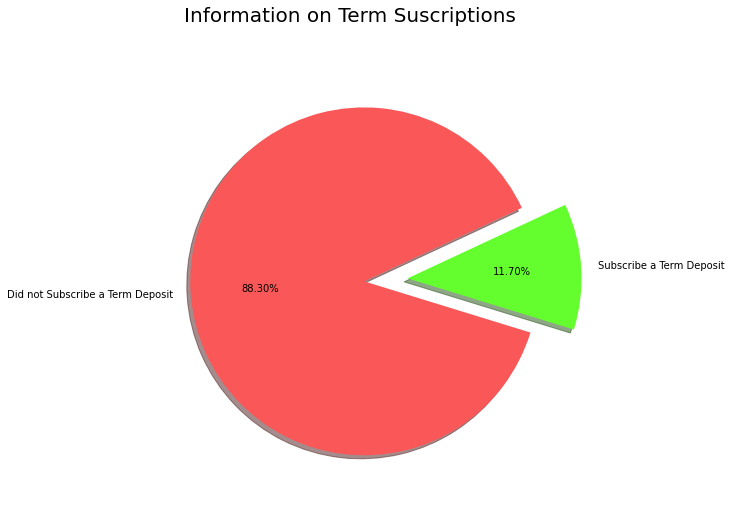

In [ ]:
# inspection about Dependent variable

plt.figure(figsize=(16,8))

colors = ['#FA5858', '#64FE2E']
labels = 'Did not Subscribe a Term Deposit', 'Subscribe a Term Deposit'

plt.suptitle('Information on Term Suscriptions', fontsize = 20)

df_count = (df.y.value_counts())
total = sum(df_count)
df_percentage = (df_count)/total*100
plt.pie(df_percentage, explode=[0, 0.25], autopct = '%1.2f%%', shadow = True, colors = colors, 
                                             labels = labels, startangle = 25)
plt.show();

- The dataset is imbalanced. 88.3% of the dependent variable is ineffective i.e the customer doesnot subscribed to the term deposit and 11.7% is otherwise.

##Bivariate Analysis

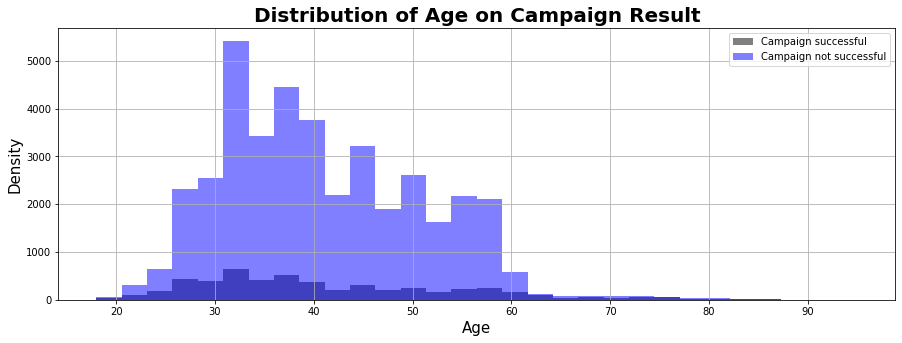

In [ ]:
# Comparing age distribution between converted vs unconverted clients

plt.figure(figsize = (15, 5))

df[df['y'] == 'yes']['age'].hist(alpha = 0.5,
                                 color = 'black',
                                 bins = 30,
                                 label = 'Campaign successful')

df[df['y'] == 'no']['age'].hist(alpha = 0.5,
                                color = 'blue',
                                bins = 30,
                                label = 'Campaign not successful')
plt.legend()
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Distribution of Age on Campaign Result', fontsize = 20, weight = 'bold')
plt.show();

- Campaign seem to be most successful among younger < 20 years old and older clients > 60 years old.

In [ ]:
# Mean age by profession

df[['job', 'age']].groupby(by = ['job'], axis = 0).mean().sort_values(by = 'age', ascending = True)

age
job                     
student        26.542644
services       38.740250
admin.         39.289886
technician     39.314598
blue-collar    40.044081
management     40.449567
self-employed  40.484484
unemployed     40.961627
entrepreneur   42.190989
housemaid      46.415323
unknown        47.593750
retired        61.626767

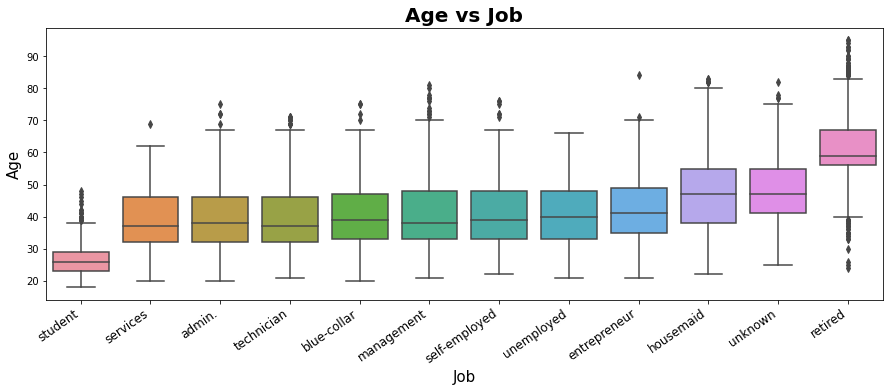

In [ ]:
# Plot age distribution of clients by profession

job_order = df[['job', 'age']].groupby(by = ['job'], axis = 0).mean().sort_values(by = 'age', ascending = True).index

plt.figure(figsize = (15, 5))
sns.boxplot(x ='job', y ='age', data = df, order = job_order)
plt.xticks(
    rotation = 35, 
    horizontalalignment = 'right',
    fontweight ='light',
    fontsize = 'large')
plt.xlabel('Job', fontsize = 15)
plt.ylabel('Age', fontsize = 15)
plt.title('Age vs Job', fontsize = 20, weight = 'bold')
plt.show();

- There are apparent outliers among both professions (young retirees and older students).

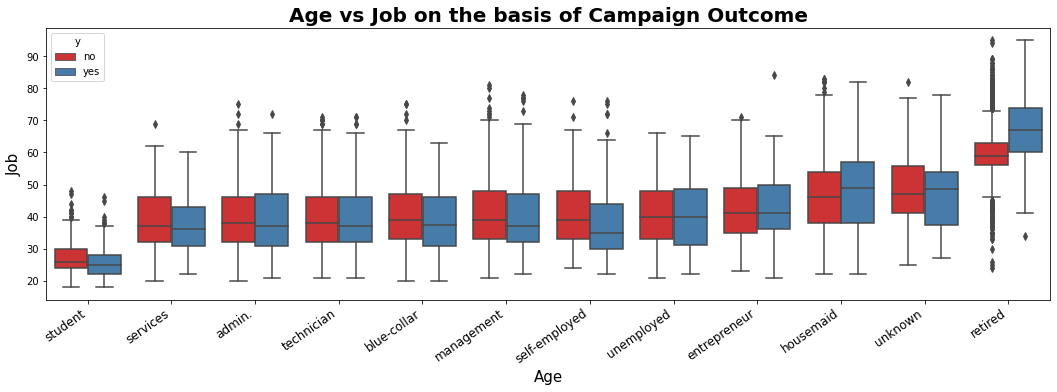

In [ ]:
# Plot age distribution of clients by profession and campaign result

plt.figure(figsize = (18, 5))
sns.boxplot(x = 'job', y = 'age', hue = 'y', data = df, order = job_order, palette = "Set1")
plt.xticks(
    rotation = 35, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'large')
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Job', fontsize = 15)
plt.title('Age vs Job on the basis of Campaign Outcome', fontsize = 20, weight = 'bold')
plt.show();

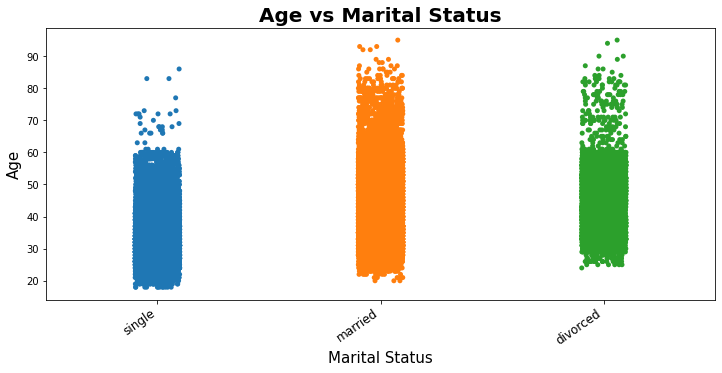

In [ ]:
# Plot age distribution of clients by marital status

marital_order = df[['marital', 'age']].groupby(by = ['marital'], axis = 0).mean().sort_values(by = 'age', ascending = True).index

plt.figure(figsize = (12, 5))
sns.stripplot(x = 'marital', y = 'age', order = marital_order, data = df)
plt.xticks(rotation = 35, 
           horizontalalignment = 'right',
           fontweight = 'light',
           fontsize = 'large')
plt.xlabel('Marital Status', fontsize = 15)
plt.ylabel('Age', fontsize = 15)
plt.title('Age vs Marital Status', fontsize = 20, weight = 'bold')
plt.show();

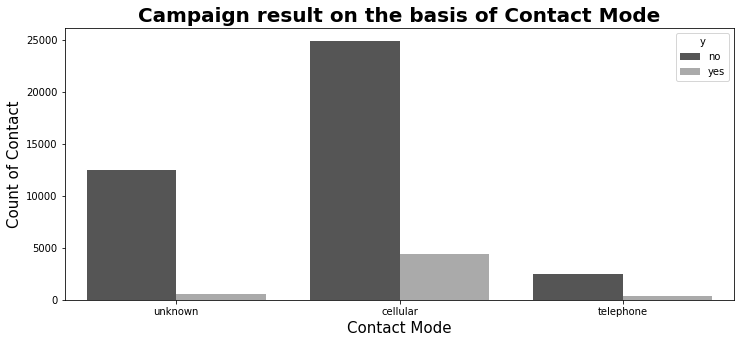

In [ ]:
# Campaign success based on whether client's contact information availability (cellular vs. telephone)

plt.figure(figsize = (12, 5))
sns.countplot(x = 'contact', hue = 'y', data = df, palette = 'gist_yarg_r')
plt.title('Campaign result on the basis of Contact Mode', fontsize = 20, weight = 'bold')
plt.ylabel('Count of Contact', fontsize = 15)
plt.xlabel('Contact Mode', fontsize = 15);

- Clients contacted through their cellular phone (as opposed to home telephone) seem likelier to respond positively to the direct marketing campaign.

## Encoding the Categorical Variables

In [ ]:
# Encoding the month column
month_dict = {'jan' : 1, 'feb' : 2, 'mar' : 3, 'apr': 4, 
              'may' : 5, 'jun' : 6, 'jul' : 7, 'aug' : 8, 
              'sep' : 9, 'oct' : 10, 'nov' : 11, 'dec' : 12}

df['month'] = df['month'].map(month_dict)

In [ ]:
# Writing a function for label encoding for education column

def ordinal_encode(education):
    if education == 'unknown':
        return 0
    elif education == 'primary':
        return 1
    elif education == 'secondary':
        return 2
    else:
        return 3
    
# Label encoding
df['education'] = df['education'].apply(ordinal_encode)

In [ ]:
# inspection about 'age' using binning method

df['age'].value_counts(normalize = False, sort = False, ascending = False, bins = 10)

(17.921999999999997, 25.7]     1336
(25.7, 33.4]                  11747
(33.4, 41.1]                  12925
(41.1, 48.8]                   8015
(48.8, 56.5]                   7066
(56.5, 64.2]                   3312
(64.2, 71.9]                    377
(71.9, 79.6]                    303
(79.6, 87.3]                    116
(87.3, 95.0]                     14
Name: age, dtype: int64

In [ ]:
# AGE

# Converting them to 4 bins according to the age bracket
def convert_age(age):
    if age <= 25:
        return 'struggling'
    elif age < 48:
        return 'stable'
    elif age < 57:
        return 'about_to_retire'
    elif age < 72:
        return 'old_age'
    else:
        return 'counting_last_breaths'

In [ ]:
# applying convert_age function to the age column and create a new feature 'cat_age'

df['cat_age'] = df['age'].apply(convert_age)

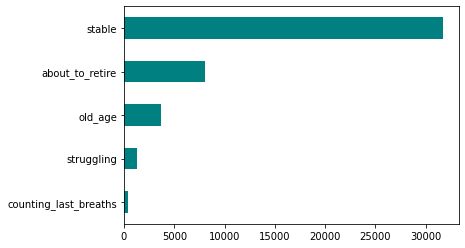

In [ ]:
# visualization after converting continuous column 'age' to categorical variable 'cat_age'

df['cat_age'].value_counts().sort_values(ascending =  True).plot(kind = 'barh',color = 'teal');

In [ ]:
# job

def cluster_jobs(job):
  new_cat1 = ['technician','services']
  new_cat2 = ['blue-collar','admin.']
  new_cat3 = ['self-employed','housemaid','entrepreneur']
  if job in new_cat1:
    return 'cat1'
  if job in new_cat2:
    return 'cat2'
  if job in new_cat3:
    return 'cat3'
  return job

In [ ]:
# applying cluster_jobs function to the job column and create a new feature 'new_jobs'

df['new_jobs'] = df['job'].apply(cluster_jobs)

In [ ]:
#default
df.default.replace({'no': 0,'yes': 1},inplace = True)

#housing
df.housing_loan.replace({'no': 0,'yes':1 },inplace = True)

#loan default
df.personal_loan.replace({'no': 0,'yes': 1},inplace = True)

#contact
df.contact.replace({'unknown': 0, 'cellular': 1, 'telephone': 1},inplace = True)

In [ ]:
df['pdays'].value_counts().to_frame().head()

pdays
-1    36954
 182    167
 92     147
 91     126
 183    126

In [ ]:
# encoding of 'pdays' column

df['contacted_before'] = df['pdays'].apply(lambda x : 1 if x != -1 else 0 )

In [ ]:
# encoding of 'prev_outcome' column

df['prev_outcome'] = df['prev_outcome'].apply(lambda x: 1 if x == 'success' else 0)

In [ ]:
# encoding of dependent variable 'y'

df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [ ]:
# dropping off 'age', 'job', 'pdays'

df.drop(['age', 'job', 'pdays'], axis = 1, inplace = True)

In [ ]:
# applying one-hot encoding to 'marital', 'cat_age', 'new_jobs' columns

pd.set_option('display.max_columns', None)
final_df = pd.get_dummies(df, columns = ['marital', 'cat_age', 'new_jobs'], drop_first = True, prefix = 'status')

final_df.head()

education  default  balance  housing_loan  personal_loan  contact  day  \
0          3        0     2143             1              0        0    5   
1          2        0       29             1              0        0    5   
2          2        0        2             1              1        0    5   
3          0        0     1506             1              0        0    5   
4          0        0        1             0              0        0    5   

   month  campaign  previous  prev_outcome  y  contacted_before  \
0      5         1         0             0  0                 0   
1      5         1         0             0  0                 0   
2      5         1         0             0  0                 0   
3      5         1         0             0  0                 0   
4      5         1         0             0  0                 0   

   status_married  status_single  status_counting_last_breaths  \
0               1              0                             0   
1               0              1                             0   
2               1              0                             0   
3               1              0                             0   
4               0              1                             0   

   status_old_age  status_stable  status_struggling  status_cat2  status_cat3  \
0               1              0                  0            0            0   
1               0              1                  0            0            0   
2               0              1                  0            0            1   
3               0              1                  0            1            0   
4               0              1                  0            0            0   

   status_management  status_retired  status_student  status_unemployed  \
0                  1               0               0                  0   
1                  0               0               0                  0   
2                  0               0               0                  0   
3                  0               0               0                  0   
4                  0               0               0                  0   

   status_unknown  
0               0  
1               0  
2               0  
3               0  
4               1

In [ ]:
# new shape of the dataet after encoding the categorical columns

print('Bank Marketing Effectiveness dataset after Label Encoding and Feature Engineering - rows:', 
      final_df.shape[0],' columns:', final_df.shape[1])

Bank Marketing Effectiveness dataset after Label Encoding and Feature Engineering - rows: 45211  columns: 26


In [ ]:
# Independent and Dependent variables separation 

X = final_df.drop('y', axis = 1)
y = final_df['y']

###Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', 
                                         max_features = 2, 
                                         random_state = 12)
  
# Training the model
extra_tree_forest.fit(X, y)
  
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_
  
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

In [ ]:
features = X.columns

In [ ]:
feature_df = pd.DataFrame({'Features': features, 'Value': feature_importance_normalized})
feature_df = feature_df.sort_values(by = ['Value'], ascending = False)

In [ ]:
#Top 15 features

feature_df = feature_df.head(15) 

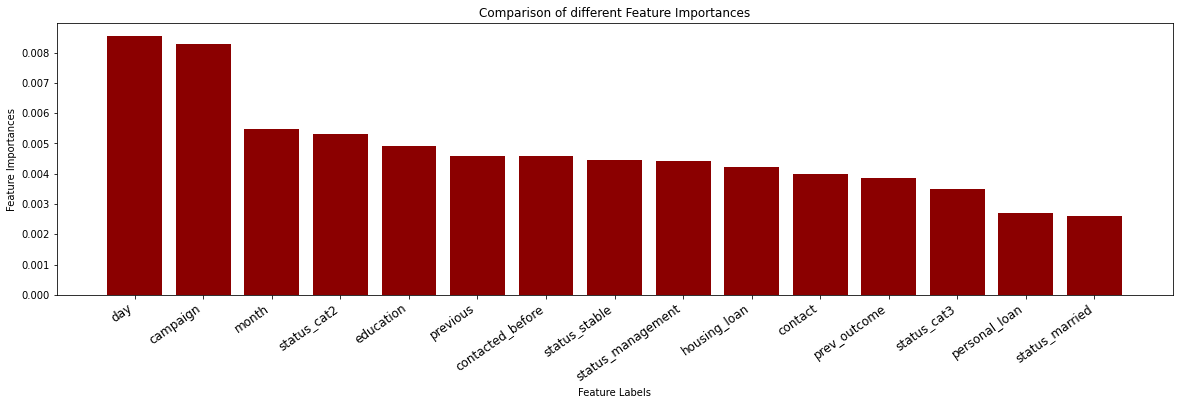

In [ ]:
# Plotting a Bar Graph to compare the model features
plt.figure(figsize = (20, 5))
plt.bar(feature_df['Features'], feature_df['Value'],color = 'Darkred')
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.xticks(
    rotation = 35, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'large');
plt.show()

In [ ]:
list_cols = list(feature_df['Features'])

# Considering only the top 15 features
X = final_df[list_cols]

In [ ]:
# Dependent variable biasness treatment - SMOTE Oversampling

from imblearn.over_sampling import SMOTE
sampler = SMOTE()

X_smote, Y_smote = sampler.fit_resample(X,y)

In [ ]:
# Original length and Resmapled Length

print('Original dataset length', len(X))
print('Resampled dataset length', len(X_smote))

Original dataset length 45211
Resampled dataset length 79844


In [ ]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size = 0.20, random_state = 1)

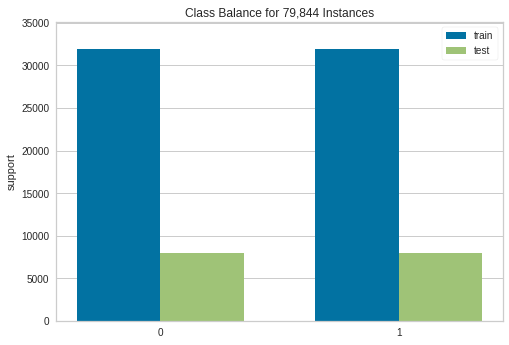

In [ ]:
# Visual inspection about train and test split of dependent variable

from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels = [0, 1])
visualizer.fit(y_train, y_test)
visualizer.poof();

## Logistic Regression 

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# predict for the test set and calculating the accuracy

y_pred_lr = clf_lr.predict(X_test)

print(f'Train Accuracy = {accuracy_score(y_train, clf_lr.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_lr)}')

Train Accuracy = 0.7315381604696674
Test Accuracy = 0.727471976955351


[[5784 2201]
 [2151 5833]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

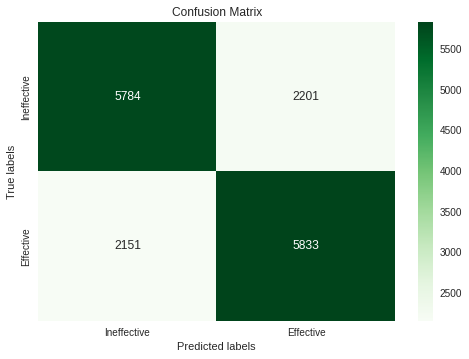

In [ ]:
# Confusion matrix for the Logistic Regression Model

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Greens', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Classification Report for the Logistic Regression Model

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      7985
           1       0.73      0.73      0.73      7984

    accuracy                           0.73     15969
   macro avg       0.73      0.73      0.73     15969
weighted avg       0.73      0.73      0.73     15969



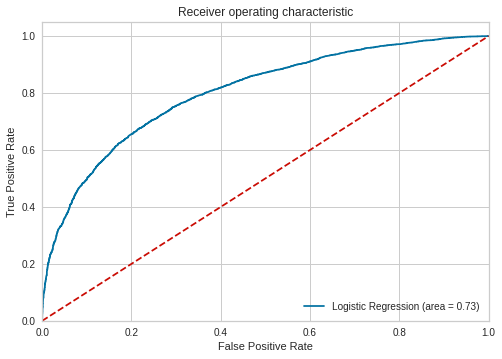

In [ ]:
# roc_auc curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, clf_lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Since a good classifier stays as far away from that line as possible we can assume that our model works fine

## DecisionTree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(max_leaf_nodes = 10, max_depth = 5, random_state = 0)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=0)

In [ ]:
# prediction

y_pred_dt = clf_dt.predict(X_test)

In [ ]:
# Train and test accuracy

print(f'Train Accuracy = {accuracy_score(y_train, clf_dt.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_dt)}')

Train Accuracy = 0.6973150684931507
Test Accuracy = 0.6977268457636671


[[6456 1529]
 [3298 4686]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

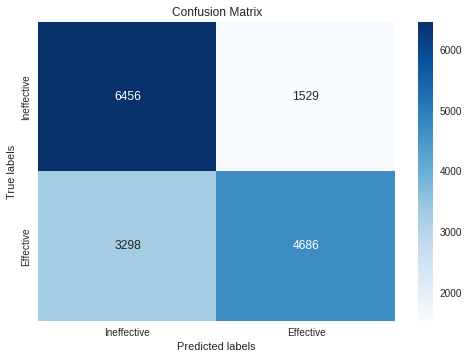

In [ ]:
# Confusion matrix for the DecisionTree Classifier

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Blues', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

### The DecisionTree Classifier model is optimum because train and test accuracy both are 82% approximately.

In [ ]:
# Classification report for the DecisionTree Classifier

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73      7985
           1       0.75      0.59      0.66      7984

    accuracy                           0.70     15969
   macro avg       0.71      0.70      0.69     15969
weighted avg       0.71      0.70      0.69     15969



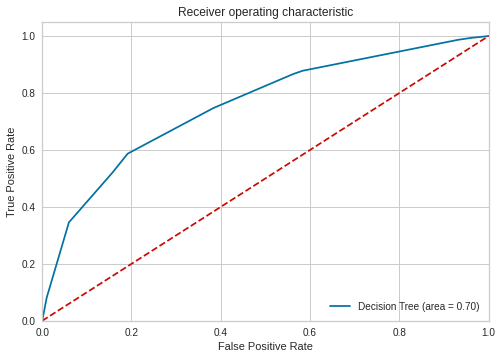

In [ ]:
dt_roc_auc = roc_auc_score(y_test, clf_dt.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_dt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('cr_dt_ROC')
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

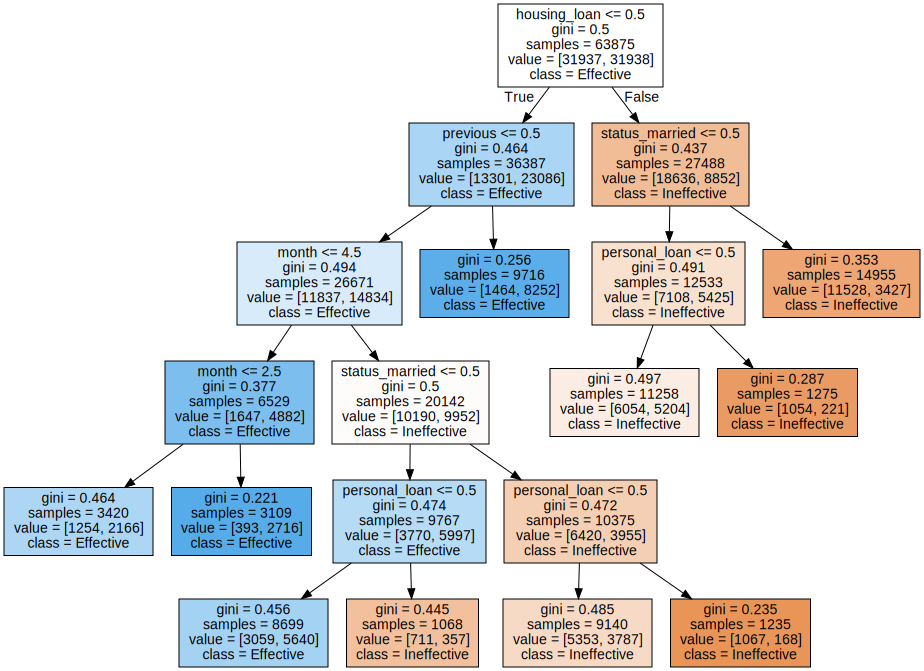

In [ ]:
graph = Source(tree.export_graphviz(clf_dt, out_file = None
   , feature_names = list_cols, class_names = ['Ineffective', 'Effective'] 
   , filled = True))
display(SVG(graph.pipe(format = 'svg')))

## RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100,
                                min_impurity_decrease=0.01,
                                max_depth = 50)

clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

In [ ]:
# Train and test accuracy

print(f'Train Accuracy = {accuracy_score(y_train, clf_rf.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred)}')

Train Accuracy = 0.7094951076320939
Test Accuracy = 0.7089986849520947


[[5789 2196]
 [2451 5533]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

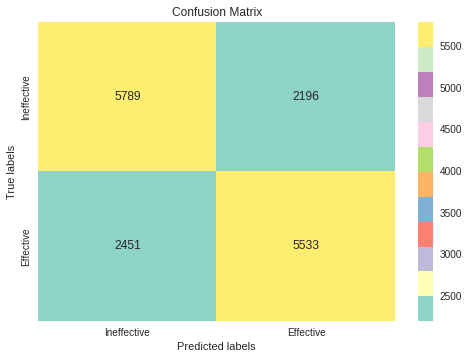

In [ ]:
# Confusion matrix for the RandomForest Classifier

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Set3', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Classification report for the RandomForest Classifier

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      7985
           1       0.72      0.69      0.70      7984

    accuracy                           0.71     15969
   macro avg       0.71      0.71      0.71     15969
weighted avg       0.71      0.71      0.71     15969



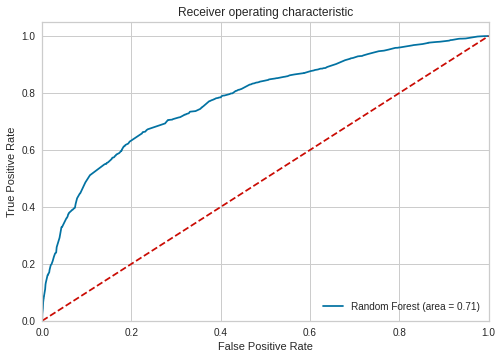

In [ ]:
rf_roc_auc = roc_auc_score(y_test, clf_rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('cr_dt_ROC')
plt.show()

In [ ]:
clf_rf.feature_importances_

array([0.        , 0.07131555, 0.01217769, 0.04322493, 0.        ,
       0.07086758, 0.04239506, 0.01283497, 0.        , 0.31943979,
       0.13224168, 0.07712346, 0.0033437 , 0.08983249, 0.12520308])

In [ ]:
df_impt = pd.DataFrame({'features': X_train.columns,'importance': clf_rf.feature_importances_})
df_impt = df_impt.sort_values(by = 'importance', ascending = False)
df_impt

features  importance
9        housing_loan    0.319440
10            contact    0.132242
14     status_married    0.125203
13      personal_loan    0.089832
11       prev_outcome    0.077123
1            campaign    0.071316
5            previous    0.070868
3         status_cat2    0.043225
6    contacted_before    0.042395
7       status_stable    0.012835
2               month    0.012178
12        status_cat3    0.003344
0                 day    0.000000
4           education    0.000000
8   status_management    0.000000

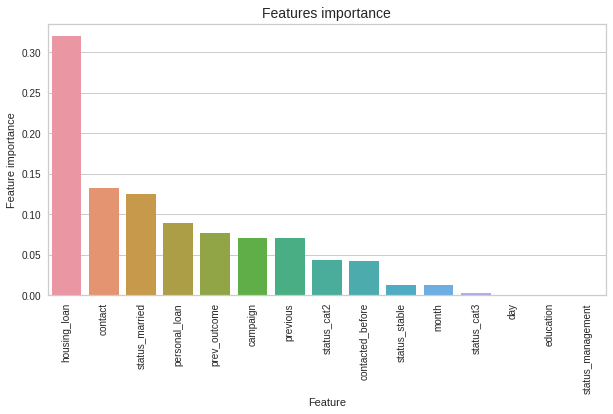

In [ ]:
tmp = pd.DataFrame({'Feature': X_train.columns, 'Feature importance': clf_rf.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
plt.figure(figsize = (10, 5))
plt.title('Features importance', fontsize = 14)
s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
plt.show()

## RandomForest Classifier(Hyperparameter Tuned)

In [ ]:
# Number of trees
n_estimators = [50, 100, 200, 250]

# Maximum depth of trees
max_depth = [5, 10, 15]

# Minimum number of samples required to split a node
min_samples_split = [50, 100, 150, 200]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40, 50, 60]

# Hyperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
param_dict

{'max_depth': [5, 10, 15],
 'min_samples_leaf': [40, 50, 60],
 'min_samples_split': [50, 100, 150, 200],
 'n_estimators': [50, 100, 200, 250]}

In [ ]:
# Implementating RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Create an instance of the RandomForestClassifier
clf_rf = RandomForestClassifier()

# Random search
random_rf = RandomizedSearchCV(estimator = clf_rf,
                       param_distributions = param_dict,
                       cv = 5, 
                       verbose = 2, 
                       scoring = 'roc_auc',
                       n_iter = 5,
                       random_state = 0)

random_rf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=   4.5s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=   4.4s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=   4.5s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=   4.5s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=   4.7s
[CV] END max_depth=10, min_samples_leaf=60, min_samples_split=150, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=60, min_samples_split=150, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=60, min_samples_split=150, n_estimators=100; total time=   2.6s
[CV] END max_depth=10, min_samples_leaf=60, min_samples_split=150, n_estimators=100; total time=   2.5s
[CV] END 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [40, 50, 60],
                                        'min_samples_split': [50, 100, 150,
                                                              200],
                                        'n_estimators': [50, 100, 200, 250]},
                   random_state=0, scoring='roc_auc', verbose=2)

In [ ]:
# Best estimator for the random forest

random_rf.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_leaf=40, min_samples_split=50)

In [ ]:
random_rf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 40,
 'min_samples_split': 50,
 'n_estimators': 100}

In [ ]:
rf_optimal_model = random_rf.best_estimator_

In [ ]:
y_pred_rf = rf_optimal_model.predict(X_test)

In [ ]:
# Train and test accuracy

print(f'Train Accuracy = {accuracy_score(y_train, rf_optimal_model.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_rf)}')

Train Accuracy = 0.7701135029354207
Test Accuracy = 0.7657962301960047


[[6468 1517]
 [2223 5761]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

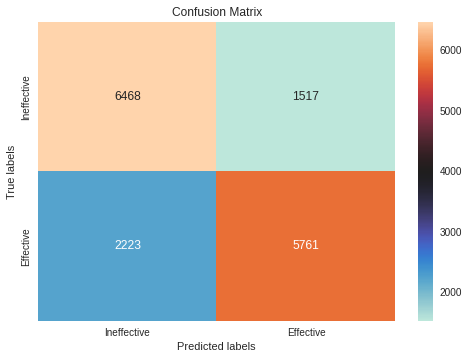

In [ ]:
# Confusion matrix for the RandomForest Classifier

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'icefire', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Classification report for the RandomForest Classifier

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78      7985
           1       0.79      0.72      0.75      7984

    accuracy                           0.77     15969
   macro avg       0.77      0.77      0.77     15969
weighted avg       0.77      0.77      0.77     15969



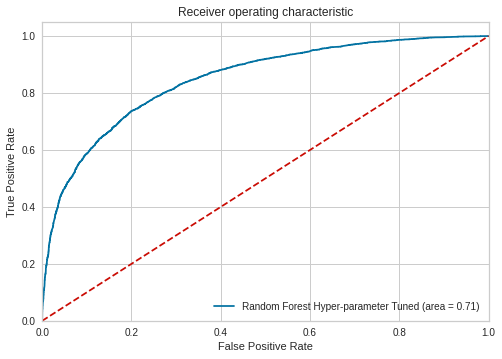

In [ ]:
rf_hp_roc_auc = roc_auc_score(y_test, rf_optimal_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_optimal_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'Random Forest Hyper-parameter Tuned (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('cr_rf_ROC')
plt.show()

## XGBRF  Classifier

In [ ]:
import xgboost as xg

# Instantiation
xgb_r = xg.XGBRFClassifier(learning_rate = 0.01, n_estimators = 100, seed = 0)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
y_pred_xgbrf = xgb_r.predict(X_test)

In [ ]:
print(f'Train Accuracy = {accuracy_score(y_train, xgb_r.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_xgbrf)}')

Train Accuracy = 0.7092133072407045
Test Accuracy = 0.7088734422944455


[[6062 1923]
 [2726 5258]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

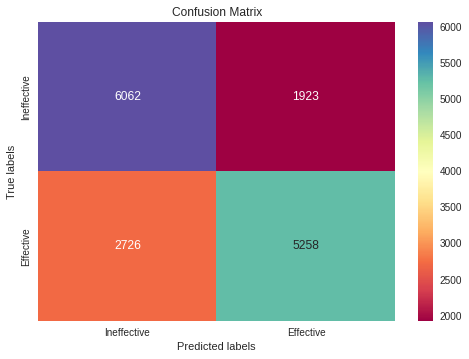

In [ ]:
# Confusion matrix for the XGBRF Classifier

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred_xgbrf)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Spectral', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Classification report for the XGBRF Classifier

print(classification_report(y_test, y_pred_xgbrf))

              precision    recall  f1-score   support

           0       0.69      0.76      0.72      7985
           1       0.73      0.66      0.69      7984

    accuracy                           0.71     15969
   macro avg       0.71      0.71      0.71     15969
weighted avg       0.71      0.71      0.71     15969



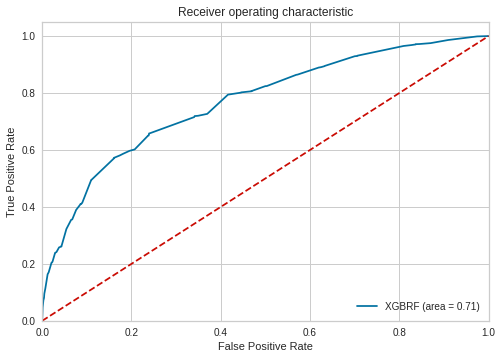

In [ ]:
xgbrf_roc_auc = roc_auc_score(y_test, xgb_r.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_r.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'XGBRF (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('cr_XGBRF_ROC')
plt.show()

## XGBoost Classifier

In [ ]:
# Instantiation
xgb_C = xg.XGBClassifier(n_estimators = 100, seed = 123)
  
# Fitting the model
xgb_C.fit(X_train, y_train)


# Predict the model
y_pred_xgb = xgb_C.predict(X_test)

print(f'Train Accuracy = {accuracy_score(y_train, xgb_C.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_xgb)}')

Train Accuracy = 0.7620821917808219
Test Accuracy = 0.7588452626964745


[[6175 1810]
 [2041 5943]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

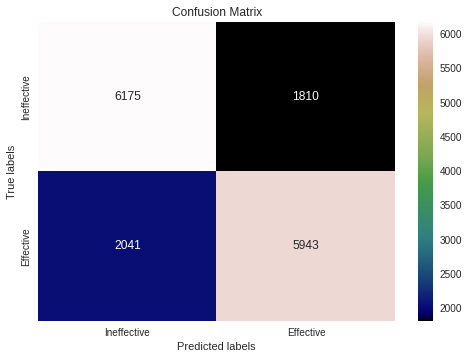

In [ ]:
# Confusion matrix for the XGBoost Classifier

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred_xgb)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'gist_earth', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Classification report for the XGBoost Classifier

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      7985
           1       0.77      0.74      0.76      7984

    accuracy                           0.76     15969
   macro avg       0.76      0.76      0.76     15969
weighted avg       0.76      0.76      0.76     15969



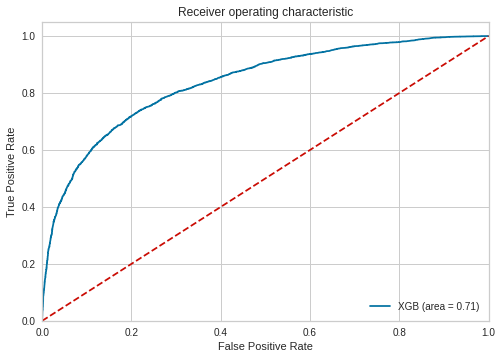

In [ ]:
xgb_roc_auc = roc_auc_score(y_test, xgb_C.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_C.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'XGB (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('cr_XGB_ROC')
plt.show()

## Model Summary

In [ ]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(['SL No.','Model_Name','Train_Accuracy', 'Test_Accuracy', 'f1-score - Class 0', 'f1-score - Class 1', 'auc_roc' ]) 
  
# Add rows 
myTable.add_row(['1',"Logistic Regression", "73%", "72%", "0.72", "0.73", "0.73"]) 
myTable.add_row(['2',"Decision Tree ", "69%", "69%", "0.73", "0.66", "0.70"])
myTable.add_row(['3',"RanodmForest Classifier ", "72%", "72%", "0.73", "0.71", "0.72"]) 
myTable.add_row(['4',"RadomizedSearchCV RandomForest Classifier", "77%", "76%", "0.77", "0.75", "0.72"]) 
myTable.add_row(['5',"Xgbrf Classifier", "71%", "71%", "0.72", "0.69", "0.71"])
myTable.add_row(['6',"Xgboost Classifier", "76%", "75%", "0.76", "0.76", "0.71"])

print(myTable)

+--------+-------------------------------------------+----------------+---------------+--------------------+--------------------+---------+
| SL No. |                 Model_Name                | Train_Accuracy | Test_Accuracy | f1-score - Class 0 | f1-score - Class 1 | auc_roc |
+--------+-------------------------------------------+----------------+---------------+--------------------+--------------------+---------+
|   1    |            Logistic Regression            |      73%       |      72%      |        0.72        |        0.73        |   0.73  |
|   2    |               Decision Tree               |      69%       |      69%      |        0.73        |        0.66        |   0.70  |
|   3    |          RanodmForest Classifier          |      72%       |      72%      |        0.73        |        0.71        |   0.72  |
|   4    | RadomizedSearchCV RandomForest Classifier |      77%       |      76%      |        0.77        |        0.75        |   0.72  |
|   5    |          

## SHAP Implementation

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 3.2 MB/s 


In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
X_shap = X_train
explainer = shap.TreeExplainer(rf_optimal_model)
shap_values = explainer.shap_values(X_shap)

In [ ]:
X_shap.shape

(63875, 15)

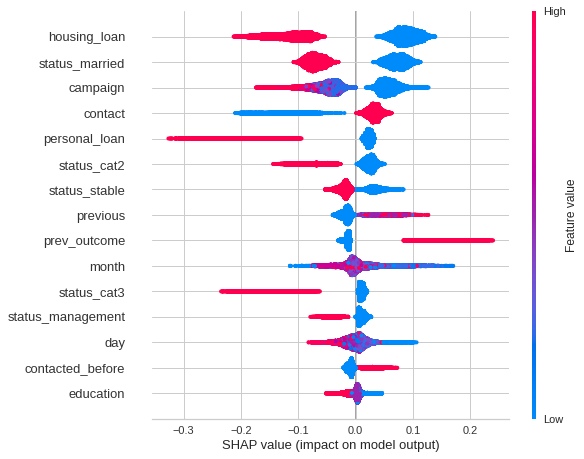

In [ ]:
shap.summary_plot(shap_values[1], X_shap, plot_type='dot')

In [ ]:
x_shap = X_test
explainer_test = shap.TreeExplainer(rf_optimal_model)
shap_values_test = explainer_test.shap_values(x_shap)

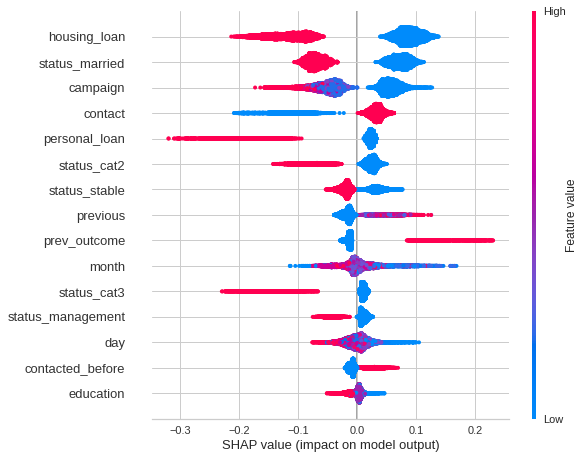

In [ ]:
shap.summary_plot(shap_values_test[1], x_shap, plot_type='dot')

###Local interpretibility

In [ ]:
index = 0
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])

In [ ]:
index = 106
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])

In [ ]:
index = 256
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])

In [ ]:
index = 12685
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])

In [ ]:
index = 2575
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])